# Taxi-PPO implementation

PPO test in the Taxi environment

In [1]:
import gym
import minerl
import numpy as np
import tensorflow as tf 
from tensorflow import keras
from collections import deque
import random
from matplotlib import pyplot as plt

env = gym.make('Taxi-v3')

D:\Programmi\Anaconda\envs\gputest\lib\site-packages\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


## Memory

Class used to memorize the trajectory and calculate the advntage

In [2]:
class Memory(object):
    
    STATE = 0
    ACTION = 1
    ACTION_PROB = 2
    REWARD = 3
    DONE = 4
    
    def __init__(self, n_trajectories, gamma = 0.4):
        self.trajectories = np.empty(n_trajectories, dtype=object)
        self.gamma = gamma
        
        
    def collect(self, state, action, action_prob, reward, done, i_episode):
        if (self.trajectories[i_episode] == None):
            self.trajectories[i_episode] = deque(maxlen=N_STEPS)
        self.trajectories[i_episode].append((state, action, action_prob, reward, done))
        
    def calculate_advantages(self):
        self.advantages = []
        self.TDerrors = [] #list of all the delta, used to uopdate the critic
        
        for trajectory in self.trajectories:
            
            advantage_trajectory = [] #list of advantages for each element in a single trajectory
            delta = []
            
            old_advantage = trajectory[-1][self.REWARD]
            delta.append(old_advantage)
            advantage_trajectory.append(old_advantage)

            for i in range(len(trajectory)-2,-1,-1):
                delta.append(trajectory[i][self.REWARD] + self.gamma*ppo.return_v_values(trajectory[i+1][self.STATE]) - ppo.return_v_values(trajectory[i][self.STATE]))
                new_advantage = delta[-1] + self.gamma*old_advantage
                
                advantage_trajectory.append(new_advantage[0])   
                
                old_advantage = new_advantage
               
            #reverse the list (at pos 0 there is the last advantage/delta)
            advantage_trajectory = list(reversed(advantage_trajectory))
            delta = list(reversed(delta))
            
            self.advantages.append(advantage_trajectory)
            self.TDerrors.append(delta)
            
        #flat all trajectories in a single deque adding the advantages (easier to sample random batches)
        self.flat_trajectories(self.trajectories, self.advantages, self.TDerrors)
    
    def flat_trajectories(self, trajectories, advantages, TDerrors):
        
        size = 0
        for trajectory in trajectories:
            size = size + len(trajectory)
        
        self.flatten_trajectories = deque(maxlen=size)
        
        for trajectory, advantage, delta in zip(trajectories, advantages, TDerrors):
            for i in range(len(trajectory)):
                self.flatten_trajectories.append((trajectory[i][self.STATE], trajectory[i][self.ACTION], trajectory[i][self.ACTION_PROB], trajectory[i][self.REWARD], advantage[i], delta[i], trajectory[i][self.DONE]))
        
        
    #pick a random batch example from the flatten list of trajectories
    def sample_experiences(self, batch_size):
        if (len(self.flatten_trajectories) >= batch_size):
            indices = np.random.permutation(len(self.flatten_trajectories))[:batch_size]
        else:
            indices = np.random.permutation(len(self.flatten_trajectories))
        batch = [self.flatten_trajectories[index] for index in indices]
        #delete form the memory the used obervations
        for index in sorted(indices, reverse=True):
            del self.flatten_trajectories[index]
        states, actions, actions_prob, rewards, advantages, TDerrors, dones = [np.array([experience[field_index] for experience in batch]) for field_index in range(7)]
        return states, actions, actions_prob, rewards, advantages, TDerrors, dones
        
    def reset(self):
        for trajectory in self.trajectories:
            trajectory.clear()

# PPO class

$ s_{t+1} $ is the observed state after the current action $ a_t $ 

Actor update formula:
$ \theta_{t+1} = \theta_t + \alpha\nabla min(r_t(\theta)\hat{A}_t, clip(r_t(\theta),1-\epsilon,1+\epsilon)\hat{A}_t)$

Critic update formula:
$ w_{t+1} = w_t + \alpha\delta_t\nabla\hat{v}(s_t,w)$

Probability ratio $ r_t(\theta) \doteq $
$ \pi_\theta(a_t | s_t) \over \pi_{\theta_old}(a_t | s_t) $

Advantage:
$ \hat{A}_t \doteq \delta_t + (\gamma\lambda)\delta_{t+1} + (\gamma\lambda)^2\delta_{t+2} + ... + (\gamma\lambda)^{T-t+1}\delta_{T-1} = \delta_t + (\gamma\lambda)\hat{A}_{t+1}$

TDerror:
$ \quad \delta_t  \doteq $
$ r_t + \gamma\hat{v}(s_{t+1},w) - \hat{v}(s_t,w) $ $ \qquad $ (if $ s_{t+1} $ is terminal then $ \hat{v}(s_{t+1},w) = 0$)

In [3]:
class PPO(object):
    
    input_shape = [1] #500 states (400 reachable)
    n_outputs = env.action_space.n # 6 actions
    
    def __init__(self, n_episodes = 1, train_steps = 100, epsilon = 0.2, alpha = 0.95):
        self.actor = self.create_actor()
        self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
        
        self.critic = self.create_critic()
        self.critic_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
        
        self.epsilon = epsilon
        self.alpha = alpha
        
        self.train_steps = train_steps
        
        self.memory = Memory(n_episodes)
        
    #create the NN of the actor
    # Given the state returns the probability of each action
    def create_actor(self):    
        actor = keras.Sequential([
            keras.layers.Dense(32, activation="relu", input_shape=self.input_shape),
            keras.layers.Dense(32, activation="relu"),
            keras.layers.Dense(self.n_outputs, activation = 'softmax') ])
        
        return actor
       
    #create the NN of the critic
    # Given the state returns the value function
    def create_critic(self):
        critic = keras.Sequential([
            keras.layers.Dense(32, activation="relu", input_shape=self.input_shape),
            keras.layers.Dense(32, activation="relu"),
            keras.layers.Dense(1) ])
        
        self.critic_loss_fn = tf.keras.losses.mean_squared_error
        
        return critic
      
    def play_one_step(self, env, observation):
        action, action_prob = self.select_action(observation)
        observation, reward, done, info = env.step(action)
        self.memory.collect(observation, action, action_prob, reward, done, i_episode)
        return observation, action, reward, done, info
        
    #select the action (returned as a number)
    def select_action(self, observation):
        
        # explanation: tf.expand_dims(observation['pov'], axis=0)
        # since we pass another input of shape (1,) -> we need to tell keras that is one image (it assumes the first dimension to be the batch)
        
        action_probabilities = self.actor.predict(np.array( [observation,])[np.newaxis, ...])[0]
        
        #choosing an action usign randomly using a "roulette wheel" approach
        r = random.random()
        
        sum_probabilities = 0
        for i in range(len(action_probabilities)):
            sum_probabilities = sum_probabilities + action_probabilities[i]
            
            if (r <= sum_probabilities):
                action = i
                break
        
        return action, action_probabilities[action]
    
    def train(self, batch_size):
        self.memory.calculate_advantages()
        
        for i_step in range(self.train_steps):
            done = self.training_step(batch_size)
            if (done):
                break
        
        self.memory.reset()
        
    #training done on the memory (the advantages must be calculated before hand)
    def training_step(self, batch_size):
        #get experiences (parts of a trajectory) from the memory
        experiences = self.memory.sample_experiences(batch_size)
        states, actions, actions_prob, rewards, advantages, TDerrors, dones = experiences
        
        done = False
        if (len(states) != batch_size):
            done = True
        
        #compute the values for the update of the actor
        
        mask = tf.one_hot(actions, self.n_outputs)

        #array of shape (64,) into array of shape (64,1)
        states =  np.array(np.array_split(states, len(states)))
        
        with tf.GradientTape() as tape:
            current_actions_prob = self.actor(states)
            
            current_action_prob = tf.reduce_sum(current_actions_prob*mask, axis=1, keepdims=True)
            old_actions_prob = tf.reshape(tf.convert_to_tensor(actions_prob), [len(states), 1])
            probability_ratio = tf.divide(current_action_prob, old_actions_prob)
        
            surrogate_arg_1 = tf.convert_to_tensor([probability_ratio[index]*advantages[index] for index in range(len(advantages))])
            surrogate_arg_2 = tf.convert_to_tensor(np.array([tf.keras.backend.clip(probability_ratio,1-self.epsilon,1+self.epsilon)[index]*advantages[index] for index in range(len(advantages))]).flatten())
            
            L = 0 - tf.minimum( surrogate_arg_1 , surrogate_arg_2 ) 
            loss = tf.reduce_mean(L)

        actor_weights = self.actor.trainable_variables
        grads = tape.gradient(loss, actor_weights)
        self.actor_optimizer.apply_gradients(zip(grads, actor_weights))
        
        #update of the critic. We need the target is the TD error
        target_v_values = tf.reshape(tf.convert_to_tensor(np.asarray(self.alpha*TDerrors).astype('float32')), (len(states), 1))

        with tf.GradientTape() as tape:
            all_v_values = self.critic(states)
            v_values = tf.reduce_sum(all_v_values*mask, axis=1, keepdims=True)
            loss = tf.reduce_mean(self.critic_loss_fn(target_v_values, v_values))
        grads = tape.gradient(loss, self.critic.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(grads, self.critic.trainable_variables))
        
        #since v changed we need to re-calculate the advantages
        #self.memory.calculate_advantages()
        
        return done
    
    def calculate_probability_ratio(self, action, observation):
        one_hot_action = tf.one_hot(action, self.n_outputs)
        
        current_action_prob = tf.reduce_sum(self.actor.predict(observation)*one_hot_action, axis=1, keepdims=True)
        old_action_prob = tf.reduce_sum(self.actor_old.predict(observation)*one_hot_action, axis=1, keepdims=True)
    
        return current_action_prob / old_action_prob
    
    def return_v_values(self, observation):
        v = self.critic.predict(np.array( [observation,])[np.newaxis, ...])[0]
        return v

## Training

In [ ]:
N_EPOCHS = 10
N_EPISODES = 3 # number of trajectories collected in one epoch
N_STEPS = 200 # max number of step for each episode

TRAIN_STEPS = 15 # number of max steps done during training. if the number of samples is less than TRAIN_STEPS*BATCH_SIZE will stop early after completing the training on all the samples
BATCH_SIZE = 64

ppo = PPO(n_episodes = N_EPISODES, train_steps = TRAIN_STEPS)

rewards = []


for i_epoch in range(N_EPOCHS):
    
    epoch_reward = 0.0
    
    for i_episode in range(N_EPISODES):
        
        observation = env.reset()
        
        episode_reward = 0.0
        
        for i_step in range(N_STEPS):   
            
            observation, action, reward, done, info = ppo.play_one_step(env, observation)

            #env.render()
            episode_reward = episode_reward + reward

            if(done or i_step == N_STEPS-1):
                print("Epoch {} Episode {} terminated after {} steps with total reward: {}".format(i_epoch, i_episode, i_step, episode_reward))
                epoch_reward = epoch_reward + episode_reward
                break
                
    rewards.append(epoch_reward/N_EPISODES)
    
    ppo.train(batch_size = 64)
    
env.close()

Epoch 0 Episode 0 terminated after 199 steps with total reward: -200.0
Epoch 0 Episode 1 terminated after 199 steps with total reward: -200.0


## Plot graph

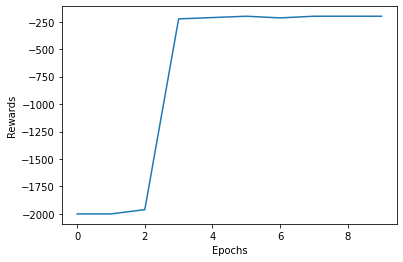

In [5]:
epochs = range(N_EPOCHS)

plt.plot(epochs, rewards)

plt.xlabel("Epochs")
plt.ylabel("Rewards")

plt.show()